# Project in Machine Learning Class

## Predict user's review sentiment

### John Koumentis, MTN2012

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import re

import nltk
nltk.download('words')
from nltk.classify import textcat
nltk.download('crubadan')
nltk.download('punkt')
from nltk.corpus import stopwords, words
from nltk.stem.porter import *

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn import metrics

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package crubadan to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package crubadan is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Load and preprocess data

The data used comes from the 'Amazon Cell Phones Reviews' dataset found in Kaggle (https://www.kaggle.com/grikomsn/amazon-cell-phones-reviews)

In [2]:
#Read the reviews dataset

df = pd .read_csv('20191226-reviews.csv')
df = df.drop('name', axis=1)

In [3]:
#Check for missing data
missing_data = df.isnull().sum()
print(missing_data)

asin                0
rating              0
date                0
verified            0
title              14
body               21
helpfulVotes    40771
dtype: int64


In [4]:
#Remove empty reviews
empty_reviews = np.where(pd.isnull(df.body))
df.drop(list(empty_reviews)[0],inplace=True)
empty_reviews

(array([ 9445, 18055, 19749, 20892, 21149, 21887, 22917, 29501, 30010,
        35596, 36845, 43415, 45899, 46470, 51628, 52176, 55171, 57837,
        61074, 62205, 64371], dtype=int64),)

In [5]:
df.head(10)

,asin,rating,date,verified,title,body,helpfulVotes
0,B0000SX2UC,3,"October 11, 2005",False,"Def not best, but not worst",I had the Samsung A600 for awhile which is abs...,1.0
1,B0000SX2UC,1,"January 7, 2004",False,Text Messaging Doesn't Work,Due to a software issue between Nokia and Spri...,17.0
2,B0000SX2UC,5,"December 30, 2003",False,Love This Phone,"This is a great, reliable phone. I also purcha...",5.0
3,B0000SX2UC,3,"March 18, 2004",False,"Love the Phone, BUT...!","I love the phone and all, because I really did...",1.0
4,B0000SX2UC,4,"August 28, 2005",False,"Great phone service and options, lousy case!",The phone has been great for every purpose it ...,1.0
5,B0000SX2UC,4,"September 25, 2005",False,Worked great for me,"Hello, I have this phone and used it until I d...",NaN
6,B0000SX2UC,5,"April 16, 2004",False,Wanna cool Nokia? You have it here!,Cool. Cheap. Color: 3 words that describe the ...,2.0
7,B0000SX2UC,4,"April 3, 2004",False,Problem with 3588i universal headset,"The 3599i is overall a nice phone, except that...",2.0
8,B0000SX2UC,5,"November 24, 2003",False,cool phone!!!!!!!!,"I've never owned a Nokia phone before, so this...",7.0
9,B0000SX2UC,3,"February 2, 2004",False,Pissed off-a little bit,ok well im in school and i need the text messa...,3.0


In [6]:
#Isolate body and rating columns in a new dataset
reviews_dataset = pd.DataFrame({'reviews':df.body.values, 'ratings':df.rating.values})
reviews_dataset.head()

,reviews,ratings
0,I had the Samsung A600 for awhile which is abs...,3
1,Due to a software issue between Nokia and Spri...,1
2,"This is a great, reliable phone. I also purcha...",5
3,"I love the phone and all, because I really did...",3
4,The phone has been great for every purpose it ...,4


I observed that there were reviews written in Spanish

In [7]:
# Identify different languages
cls = textcat.TextCat()
language = reviews_dataset['reviews'][0:10].apply(cls.guess_language)

C:\Users\John\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ratings', ylabel='count'>

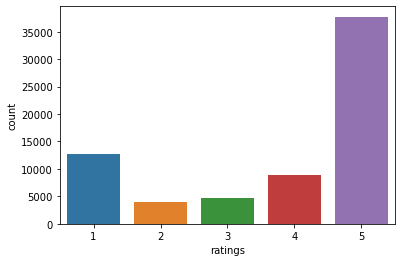

In [8]:
# Check the ratings count

sns.countplot(reviews_dataset['ratings'])

C:\Users\John\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='ratings', ylabel='count'>

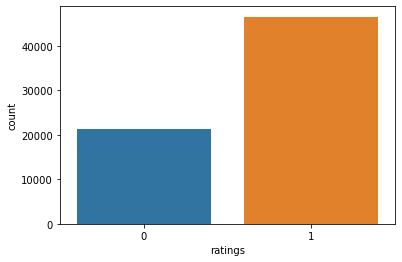

In [9]:
sentiment_dict = {1:0, 2:0, 3:0, 4:1, 5:1}
reviews_dataset['ratings'].replace(sentiment_dict,inplace=True)
sns.countplot(reviews_dataset['ratings'])

In [10]:
reviews = reviews_dataset.reviews
labels = reviews_dataset.ratings
reviews[0]

"I had the Samsung A600 for awhile which is absolute doo doo. You can read my review on it and detect my rage at the stupid thing. It finally died on me so I used this Nokia phone I bought in a garage sale for $1. I wonder y she sold it so cheap?... Bad: ===> I hate the menu. It takes forever to get to what you want because you have to scroll endlessly. Usually phones have numbered categories so u can simply press the # and get where you want to go. ===> It's a pain to put it on silent or vibrate. If you're in class and it rings, you have to turn it off immediately. There's no fast way to silence the damn thing. Always remember to put it on silent! I learned that the hard way. ===> It's so true about the case. It's a mission to get off and will break ur nails in the process. Also, you'll damage the case each time u try. For some reason the phone started giving me problems once I did succeed in opening it. ===> Buttons could be a bit bigger. Vibration could be stronger. Good: ===> Recep

### Check Positive and Negative usage of words

In [11]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
total_counts = Counter()

In [12]:
# Loop over all the words in all the reviews and increment the counts in the appropriate counter objects
for i in range(len(reviews)):
    for word in reviews[i].split(" "):
        total_counts[word] += 1
        if labels[i] == 1:
            positive_counts[word] += 1
        else:
            negative_counts[word] += 1
        

In [13]:
pos_neg_ratios = Counter()

# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio
        
# Convert ratios to logs
for word,ratio in pos_neg_ratios.most_common():
    pos_neg_ratios[word] = np.log(ratio)

In [14]:
print("Pos-to-neg ratio for 'the' = {}".format(pos_neg_ratios["the"]))
print("Pos-to-neg ratio for 'great' = {}".format(pos_neg_ratios["great"]))
print("Pos-to-neg ratio for 'broke' = {}".format(pos_neg_ratios["broke"]))

Pos-to-neg ratio for 'the' = 0.46373253753702104
Pos-to-neg ratio for 'great' = 1.7112282963603693
Pos-to-neg ratio for 'broke' = -0.19341737104900908


In [15]:
#list(pos_neg_ratios.most_common())[0:40]

In [16]:
#list(reversed(pos_neg_ratios.most_common()))[0:40]

In [17]:
#stopwords.words("greek")

In [18]:
vocab = set(nltk.corpus.words.words())

### Machine Learning Pipeline

In [19]:
X = reviews_dataset['reviews']
y = reviews_dataset['ratings']

In [20]:
def model_training(X,y,vocabulary=None,stop_words=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=4)

    model_clf = Pipeline([('tfidf', TfidfVectorizer(vocabulary=vocabulary, stop_words=stop_words)),
                     ('clf', LinearSVC()),
    ])

    # Feed the training data through the pipeline
    model_clf.fit(X_train, y_train) 

    # Form a prediction set
    predictions = model_clf.predict(X_test)

    # Report the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_test,predictions)
    print('Confusion Matrix\n{}\n'.format(confusion_matrix))

    # Create a classification report
    report = metrics.classification_report(y_test,predictions)
    print('Classification report\n{}\n'.format(report))

    # Calculate the overall accuracy
    accuracy_score = metrics.accuracy_score(y_test,predictions)
    print('Overall accuracy: {}'.format(accuracy_score))
    
    return model_clf

In [21]:
text_clf = model_training(X,y)

Confusion Matrix
[[ 5752  1244]
 [ 1015 14418]]

Classification report
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      6996
           1       0.92      0.93      0.93     15433

    accuracy                           0.90     22429
   macro avg       0.89      0.88      0.88     22429
weighted avg       0.90      0.90      0.90     22429


Overall accuracy: 0.8992821793214142


In [22]:
text_clf = model_training(X,y,stop_words=stopwords.words('english'))

Confusion Matrix
[[ 5581  1415]
 [ 1118 14315]]

Classification report
              precision    recall  f1-score   support

           0       0.83      0.80      0.82      6996
           1       0.91      0.93      0.92     15433

    accuracy                           0.89     22429
   macro avg       0.87      0.86      0.87     22429
weighted avg       0.89      0.89      0.89     22429


Overall accuracy: 0.8870658522448616


In [23]:
text_clf = model_training(X,y,vocabulary=vocab,stop_words=stopwords.words('english'))

Confusion Matrix
[[ 5314  1682]
 [ 1133 14300]]

Classification report
              precision    recall  f1-score   support

           0       0.82      0.76      0.79      6996
           1       0.89      0.93      0.91     15433

    accuracy                           0.87     22429
   macro avg       0.86      0.84      0.85     22429
weighted avg       0.87      0.87      0.87     22429


Overall accuracy: 0.8744928440857818


In [24]:
new_review = 'It\'s a great phone. I dont regret buying.'
text_clf.predict([new_review])

array([1], dtype=int64)

In [25]:
r = text_clf[0].transform([reviews[0]])

In [26]:
len(r.data)

111

In [27]:
len(reviews[0].split(" "))

327

In [28]:
tfidf = TfidfVectorizer(stop_words=stopwords.words('english'))

In [29]:
tfidf.fit_transform(reviews)

<67965x35305 sparse matrix of type '<class 'numpy.float64'>'
	with 1570495 stored elements in Compressed Sparse Row format>